https://comrade-xl.ru/2021/08/05/py-combine-xl-sheets/

In [1]:
#!pip install xlrd

#!pip install --py luxwidget
#!pip enable --py luxwidget

In [2]:
import pandas as pd
import xlwings as xw
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
#import lux

Створюємо об'єкт ExcelFile.

In [3]:
xlsx=pd.ExcelFile('temp_datas.xls')

Отримуємо список книг

In [4]:
worksheets = xlsx.sheet_names

Створюємо список, в якому кожний елемент - це датафрейм із однієї книги.

In [5]:
worksheets_dfs = []

for worksheet in worksheets:
    data = pd.read_excel(xlsx,
                         sheet_name=worksheet)
    data['worksheet'] = worksheet
    worksheets_dfs.append(data)

Обєднати всі датафрейми із списку.

In [6]:
meteo_data = pd.concat(worksheets_dfs)

In [7]:
meteo_data["date"]=pd.to_datetime(meteo_data["Timestamp for sample frequency every 1 min"]).dt.date
meteo_data["months"]=pd.to_datetime(meteo_data["Timestamp for sample frequency every 1 min"]).dt.month_name()

In [8]:
#meteo_data.head()
#meteo_data.sample(5)

<AxesSubplot:xlabel='months', ylabel='Temperature_Celsius'>

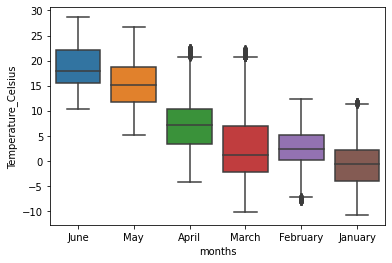

In [9]:
%matplotlib inline

sns.boxplot(x="months", y="Temperature_Celsius", data=meteo_data)

In [10]:
meteo_data.describe()

,Temperature_Celsius,Relative_Humidity,VPD,DEWPOINT_Celsius
count,233924.000000,233924.000000,233924.000000,233924.000000
mean,6.506390,67.239271,0.414069,0.240799
std,7.970312,17.459970,0.421722,6.793514
min,-10.781494,15.617889,0.001900,-14.292800
25%,0.007954,55.021805,0.135000,-4.885800
50%,5.467030,70.534270,0.251700,-1.205050
75%,12.320366,80.978910,0.520825,5.547700
max,28.643967,99.808260,2.561300,19.240300


# Середні значення показників по місяцях

In [11]:
meteo_data_grouped_mean=meteo_data.groupby('months').mean()

#Групування зведеної таблиці по місяцях в послідовному порядку (відповідно до послідовності в списку 'cats'),
#а не за алфавітом
#https://stackoverflow.com/questions/40816144/pandas-series-sort-by-month-index
cats = ['January', 'February', 'March', 'April','May','June', 'July', 'August','September', 'October', 'November', 'December']
meteo_data_grouped_mean.index=pd.CategoricalIndex(meteo_data_grouped_mean.index, categories=cats, ordered=True)
meteo_data_grouped_mean=meteo_data_grouped_mean.sort_index()

meteo_data_grouped_mean

,Temperature_Celsius,Relative_Humidity,VPD,DEWPOINT_Celsius
months,,,,
January,-0.519204,77.272075,0.143719,-4.168665
February,2.636490,69.090018,0.245345,-2.672834
March,2.909378,58.798660,0.403840,-5.473093
April,7.258133,70.175830,0.354353,1.669866
May,15.372196,58.869959,0.808000,6.729007
June,18.702162,73.316560,0.675308,13.397967


In [12]:
grouped_mean=meteo_data.groupby('date').mean().rename(columns={'Temperature_Celsius':  'mean_temperature_celsius',
                                                               'Relative_Humidity': 'mean_relative_humidity',
                                                               'VPD': 'mean_vpd',
                                                               'DEWPOINT_Celsius': 'mean_dewpoint_celsius'})

In [13]:
#Розрахунок середніх денних показників та виокремлення окремої колонки активних середньодобових температур,
#де середньодобова температура більша 10 град. цельсія.
grouped_mean['act_mean_temperature_celsius']=grouped_mean['mean_temperature_celsius'].apply(lambda x: x if x >10 else 0)
grouped_mean["months"]=pd.to_datetime(grouped_mean.index).month_name()

#grouped_mean.sample(5)

# Сума активних температур

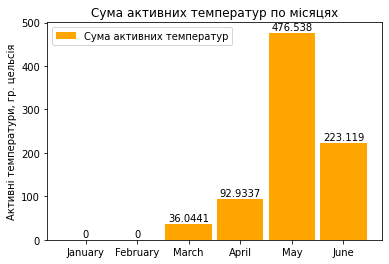

In [14]:
grouped_sum=grouped_mean.groupby('months').sum()

#Групування зведеної таблиці по місяцях в послідовному порядку (відповідно до послідовності в списку 'cats'),
#а не за алфавітом
#https://stackoverflow.com/questions/40816144/pandas-series-sort-by-month-index
cats = ['January', 'February', 'March', 'April','May','June', 'July', 'August','September', 'October', 'November', 'December']
grouped_sum.index=pd.CategoricalIndex(grouped_sum.index, categories=cats, ordered=True)
grouped_sum=grouped_sum.sort_index()

#Налаштування відображення гістограми
#https://matplotlib.org/3.5.0/plot_types/basic/bar.html#sphx-glr-plot-types-basic-bar-py

labels=grouped_sum.index
sum_act_temp=grouped_sum['act_mean_temperature_celsius']
width = 0.90

fig, ax = plt.subplots()

bar1=ax.bar(labels, sum_act_temp, width, label='Сума активних температур', color='orange')

ax.set_ylabel('Активні температури, гр. цельсія')
ax.set_title('Сума активних температур по місяцях')
ax.legend()

ax.bar_label(bar1, padding=1)

plt.show()

## Значення суми активних температур 2022 р. (в р-ні с. Новичка, Калуського району)

In [15]:
print('Сума активних температур (>10 гр. цельсія) становить', grouped_mean['act_mean_temperature_celsius'].sum().round(decimals=2),' гр. цельсія')

Сума активних температур (>10 гр. цельсія) становить 828.63  гр. цельсія
